In [1]:
import bq  
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import matplotlib.dates as mdates
import rasterio as rio
import affine

/Users/David/Desktop/Jobs/GlobalFishingWatch/github/vessel-maps/utilities/pipa_paper/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
client = bq.Client.Get()
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer


In [21]:
# adjust these to save the file for anywhere in the world

min_lat_box = 10
max_lat_box = 20
min_lon_box = -130
max_lon_box = -120 #135.26 135.20 131.20 131.26

one_over_scale = 10
scale = .1

out_tif = "CAFE"
path_to_file ="../data/fishing_hours/"


In [22]:

q = '''SELECT
  FLOOR(lat*'''+str(one_over_scale)+''') lat_bin,
  FLOOR(lon*'''+str(one_over_scale)+''') lon_bin,
  SUM((last_hours+next_hours)/2) fishing_time
FROM
  [scratch_global_fishing_raster.2015_with_score_and_hours]
WHERE
  lat IS NOT NULL
  AND lon IS NOT NULL
  AND lat >'''+str(min_lat_box)+'''
  AND lon <'''+str(max_lon_box)+'''
  AND lat < '''+str(max_lat_box)+'''
  AND lon >'''+str(min_lon_box)+'''
  AND mmsi IN (
  SELECT
    mmsi
  FROM
    [scratch_bjorn.2015_combined_fishing])
  AND measure_new_score >= 0.5
GROUP BY
  lat_bin,
  lon_bin'''

fishing_points = Query(q)

Waiting on bqjob_r78b033d690de239f_000001545e822c7f_4 ... (34s) Current status: DONE   
Query time: 36.5157020092 seconds.


In [23]:
lats = []
lons = []
ts = []
for row in fishing_points:
    lat = int(float(row[0]))
    lon = int(float(row[1]))
    t = float(row[2])
    ts.append(t)
    lats.append(lat)
    lons.append(lon)

In [24]:
lats = np.array(lats)
lons = np.array(lons)
ts = np.array(ts)

In [25]:
min_lat_ras = lats.min()
max_lat_ras = lats.max()
min_lon_ras = lons.min()
max_lon_ras = lons.max()

min_lat = min_lat_ras*scale
min_lon = min_lon_ras*scale
max_lat = max_lat_ras*scale
max_lon = max_lon_ras*scale

num_lats = (max_lat_ras - min_lat_ras)+1
num_lons = (max_lon_ras - min_lon_ras)+1

grid = np.zeros((num_lats,num_lons))

for lt,ln,hr in zip(lats,lons,ts):
    lat_index = lt - min_lat_ras
    lon_index = ln - min_lon_ras
    grid[lat_index][lon_index]+=hr


profile = {
    'crs': 'EPSG:4326',
    'nodata': -9999,
    'dtype': rio.float32,
    'height': num_lats,
    'width': num_lons,
    'count': 1,
    'driver':"GTiff",
    'transform': affine.Affine(scale, 0, min_lon, 
              0, -scale, max_lat)}

with rio.open(path_to_file + out_tif + ".tif", 'w', **profile) as dst:
    dst.write(np.flipud(grid).astype(profile['dtype']), indexes=1)

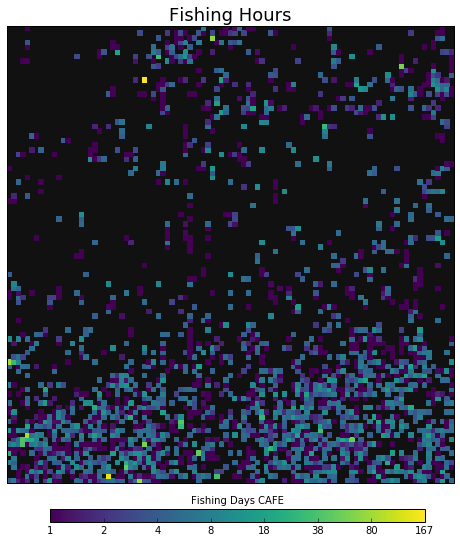

In [26]:
plt.rcParams["figure.figsize"] = [8,9]

firstlat = max_lat
lastlat =  min_lat
firstlon = min_lon
lastlon = max_lon

    
lat_boxes = np.linspace(lastlat,firstlat,num=num_lats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=num_lons,endpoint=False)

fig = plt.figure()
extra = 0 # degrees of buffer around image
m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
          llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary(fill_color='#111111')
m.drawcoastlines(linewidth=.2)
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)

x = np.linspace(firstlon, lastlon, num_lons)
y = np.linspace(lastlat, firstlat, num_lats)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Hours"
plt.title(t, color = "#000000", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.65, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Hours '+out_tif,labelpad=-40, y=0.45, color = "#000000")
plt.savefig(path_to_file + out_tif +".png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()


-90